In [1]:
import seaborn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [179]:
class Circle:
    def __init__(self, radius=1.0, center=(0.0, 0.0)):
        self.x, self.y = center
        self.radius = radius
    
    def set_center_xy(self, x, y):
        self.x = x
        self.y = y
        
    def shift_center_xy(self, vec):
        self.x += vec[0]
        self.y += vec[1]

    def get_radius(self):
        return self.radius
    
    def set_radius(self, radius):
        self.radius = radius
    
    def get_circumference(self):
        return self.radius * 2 * np.pi
    
    def get_diameter(self):
        return self.radius * 2
    
    def scale_radius(self, scale):
        self.radius *= scale
    
    def scale_circumference(self, scale):
        self.set_circumference(self.get_circumference() * scale)
    
    def get_area(self):
        return self.radius * self.radius * np.pi
    
    def set_area(self, area):
        self.radius = np.sqrt(area / np.pi)

    def set_circumference(self, circumference):
        self.radius = circumference / (2 * np.pi)
        
    def set_diameter(self, diameter):
        self.radius = diameter / 2
        
    def set_center_rtheta(self, r, theta):
        self.set_center_xy(r*np.cos(theta), r*np.sin(theta))
    
    def _gen_arc(self, start, stop, num):
        return np.linspace(start=start, stop=stop, num=num)
    
    def plot_arc_on_axes(self, ax, pi_start=0.0, pi_end=2*np.pi, n=100,*args, **kwargs):
        pi_start = pi_start
        pi_end = pi_end
        arc = self._gen_arc(pi_start, pi_end, n)
        x = self.x + self.radius * np.cos(arc)
        y = self.y + self.radius * np.sin(arc)
        ax.plot(x, y, **kwargs)
        

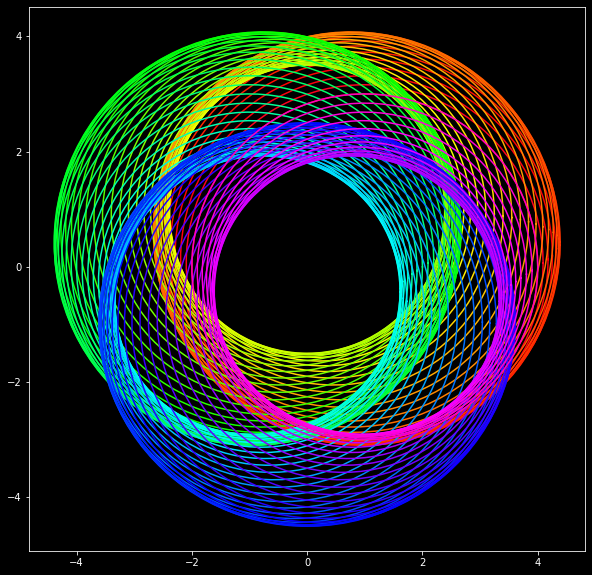

In [228]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
c = Circle()
edges = c._gen_arc(0, 2*np.pi, 99)

plt.style.use('dark_background')
for i, e in enumerate(edges):
    colors = plt.cm.gist_rainbow(np.linspace(0,1,len(edges)))
    r = 3 + 0.5*np.sin(3*e)
    c.set_center_rtheta(1.0, e)
    c.set_radius(r)
    c.plot_arc_on_axes(ax, color=colors[i])
plt.savefig("loops.png")